# Imports and Dependancies

In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Loading and Cleaning Data

## Initial  Extraction

In [ ]:
combined_path = # add path to combined file
action_data_path = # add path to action data
bias_data = pd.read_csv(combined_path)
action_data = pd.read_csv(action_data_path)

In [ ]:
bias_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10075 entries, 0 to 10074
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   action        10075 non-null  object
 1   sample        10075 non-null  int64 
 2   imgPath       10075 non-null  object
 3   vidPath       10075 non-null  object
 4   dataset       10075 non-null  object
 5   response      10000 non-null  object
 6   one_person    10075 non-null  object
 7   face_visible  10075 non-null  object
 8   gender        10075 non-null  object
 9   age           10075 non-null  object
 10  race          10075 non-null  object
dtypes: int64(1), object(10)
memory usage: 865.9+ KB


## Cleaning and Filtering

In [ ]:
print(bias_data['gender'].value_counts())
print(bias_data['age'].value_counts())
print(bias_data['race'].value_counts())

gender
male      5012
female    3403
ERROR     1658
other        2
Name: count, dtype: int64
age
adult          4666
teenager       2371
ERROR          1664
middle-aged     716
child           553
senior          105
Name: count, dtype: int64
race
white              5929
ERROR              1657
indian              852
east asian          840
black               345
southeast asian     223
latino              134
middle eastern       95
Name: count, dtype: int64


In [ ]:
bias_data = bias_data[bias_data['one_person'] == "yes"]               # remove samples with more than one person
bias_data = bias_data[bias_data['face_visible'] == "visible"]         # remove samples without face visible
bias_data = bias_data[~(bias_data == 'ERROR').any(axis = 1)]          # remove any samples that have an error value

In [ ]:
print(bias_data['gender'].value_counts())
print(bias_data['age'].value_counts())
print(bias_data['race'].value_counts())

gender
male      3703
female    2355
Name: count, dtype: int64
age
adult          3247
teenager       1702
middle-aged     649
child           377
senior           83
Name: count, dtype: int64
race
white              4295
east asian          607
indian              601
black               220
southeast asian     154
latino              106
middle eastern       75
Name: count, dtype: int64


In [ ]:
bias_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6058 entries, 0 to 10074
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   action        6058 non-null   object
 1   sample        6058 non-null   int64 
 2   imgPath       6058 non-null   object
 3   vidPath       6058 non-null   object
 4   dataset       6058 non-null   object
 5   response      5983 non-null   object
 6   one_person    6058 non-null   object
 7   face_visible  6058 non-null   object
 8   gender        6058 non-null   object
 9   age           6058 non-null   object
 10  race          6058 non-null   object
dtypes: int64(1), object(10)
memory usage: 567.9+ KB


In [ ]:
def UnderSample(data, bias_category):
    # goes -> actions -> category options and then samples based on the max allowed ammount
    # random state is needed to make sure the samples values are the same
    undersampled_data = (data.groupby('action', group_keys=False)
                        .apply(lambda action: action.groupby(bias_category, group_keys=False)
                        .apply(lambda category: category.sample(n = int(min(len(category), len(action) * .66)), random_state=6412)))
                        .reset_index(drop=True))
    return undersampled_data

bias_data = UnderSample(bias_data, 'gender')
bias_data = UnderSample(bias_data, 'age')
bias_data = UnderSample(bias_data, 'race')

<ipython-input-9-c222e5e24174>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda category: category.sample(n = int(min(len(category), len(action) * .66)), random_state=6412)))
<ipython-input-9-c222e5e24174>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda category: category.sample(n = int(min(len(category), len(action) * .66)), random_state=6412)))
<ipython-input-9-c222e5e24174>:6

In [ ]:
print(bias_data['gender'].value_counts())
print(bias_data['age'].value_counts())
print(bias_data['race'].value_counts())

gender
male      2157
female    1697
Name: count, dtype: int64
age
adult          2078
teenager       1050
middle-aged     407
child           271
senior           48
Name: count, dtype: int64
race
white              2528
east asian          461
indian              444
black               164
southeast asian     114
latino               82
middle eastern       61
Name: count, dtype: int64


In [ ]:
bias_data = bias_data.groupby('action').filter(lambda x: len(x) > 10) # remove actions that have lost the majority of samples

In [ ]:
print(bias_data['gender'].value_counts())
print(bias_data['age'].value_counts())
print(bias_data['race'].value_counts())

gender
male      1020
female     914
Name: count, dtype: int64
age
adult          1025
teenager        526
middle-aged     213
child           129
senior           41
Name: count, dtype: int64
race
white              1127
east asian          314
indian              235
black                86
southeast asian      71
latino               53
middle eastern       48
Name: count, dtype: int64


In [ ]:
len(bias_data["action"].unique())

142

In [ ]:
bias_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1934 entries, 6 to 3848
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   action        1934 non-null   object
 1   sample        1934 non-null   int64 
 2   imgPath       1934 non-null   object
 3   vidPath       1934 non-null   object
 4   dataset       1934 non-null   object
 5   response      1877 non-null   object
 6   one_person    1934 non-null   object
 7   face_visible  1934 non-null   object
 8   gender        1934 non-null   object
 9   age           1934 non-null   object
 10  race          1934 non-null   object
dtypes: int64(1), object(10)
memory usage: 181.3+ KB


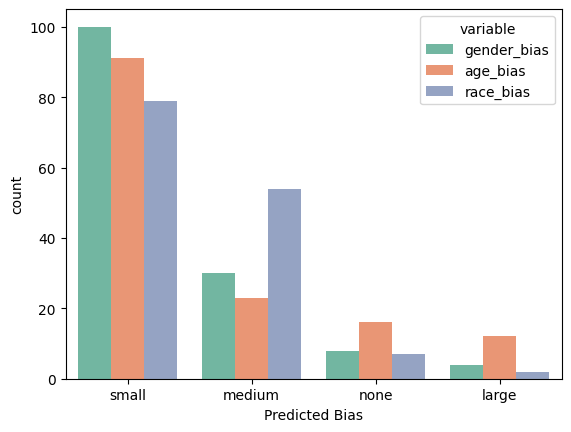

In [ ]:
filtered_action_data = action_data[action_data["action"].isin(bias_data["action"].unique())]
data_filtered = filtered_action_data.drop(columns=['action', 'reasoning'])
melted = data_filtered.melt(value_vars=data_filtered.columns)
sns.countplot(data = melted, x='value', hue = 'variable', palette='Set2', order = melted['value'].value_counts().index)

#plt.title('GPT4 Bias Prediction for Actions in HAA500-B')
plt.xlabel('Predicted Bias')
plt.ylabel('count')
plt.show()

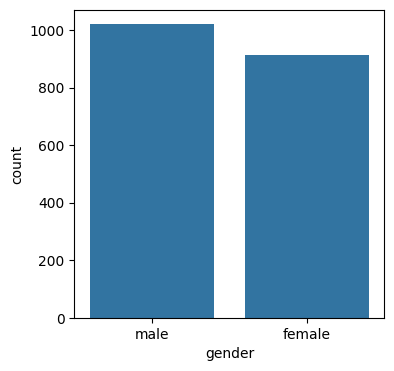

In [ ]:
plt.figure(figsize=(4, 4))
sns.countplot(x='gender', data=bias_data, order=bias_data['gender'].value_counts().index)
#plt.title('HAA500-B Class Distribution (Gender)')
plt.show()

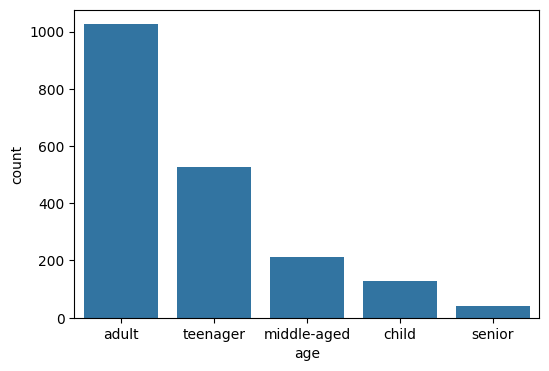

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='age', data=bias_data, order=bias_data['age'].value_counts().index)
#plt.title('HAA500-B Class Distribution (Age)')
plt.show()

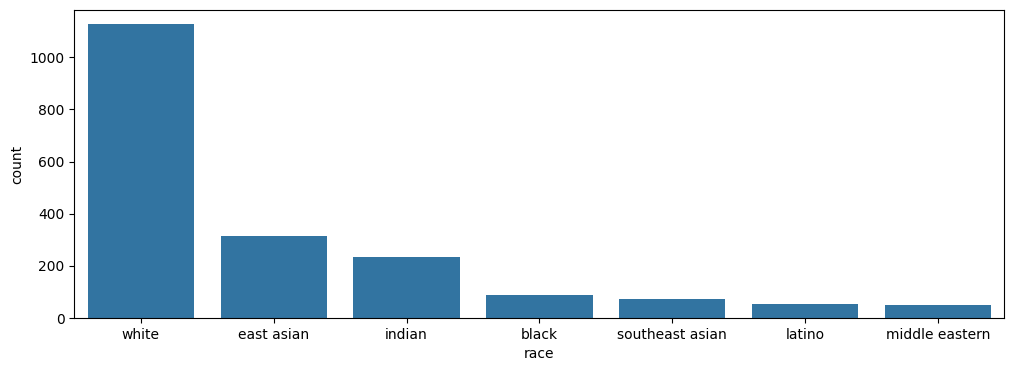

In [ ]:
plt.figure(figsize=(12, 4))
sns.countplot(x='race', data=bias_data, order=bias_data['race'].value_counts().index)
#plt.title('HAA500-B Class Distribution (Race)')
plt.show()

# Experimental Results

In [ ]:
def GetScores(data, bias_category, truth, pred):
    scores = (data.groupby(bias_category)
              .apply(lambda bias_level: [(bias_level[truth] == bias_level[pred]).mean(),
                                          f1_score(bias_level[truth], bias_level[pred], average = 'macro', zero_division = 0),
                                          len(bias_level)], include_groups=False))
    formatted = []

    for bias_level in ['none', 'small', 'medium', 'large']:
        formatted.append({'bias_category': bias_category, 'bias_level': bias_level, 'acc': scores[bias_level][0], 'f1': scores[bias_level][1], 'count': scores[bias_level][2]})

    formatted = pd.DataFrame(formatted)

    all_count = formatted['count'].sum()
    all = {'bias_category': bias_category,
            'bias_level': 'all',
            'acc': formatted['acc'].mul(formatted['count']).sum() / all_count,
            'f1': formatted['f1'].mul(formatted['count']).sum() / all_count,
            'count': all_count}

    formatted.loc[len(formatted)] = all

    return formatted

def EvalData(truth, pred, action_data):
    # merge data
    data = pd.merge(truth, pred, on = ['imgPath', 'action'], suffixes = ('_truth', '_pred'))
    data = pd.merge(data, action_data, on = 'action', how = 'left')

    # score data
    scores = []

    # bias data
    bias_categorys = ['gender_bias', 'age_bias', 'race_bias']
    bias_levels = ['none', 'small', 'medium', 'large', 'all']

    # goes -> category -> level and finds the accuracy and f1 scores
    gender_scores = GetScores(data, 'gender_bias', 'gender_truth', 'gender_pred')
    age_scores = GetScores(data, 'age_bias', 'age_truth', 'age_pred')
    race_scores = GetScores(data, 'race_bias', 'race_truth', 'race_pred')

    scores = pd.concat([gender_scores, age_scores, race_scores], axis=0, ignore_index=True)

    all_count = scores['count'].sum()
    all = {'bias_category': 'all',
            'bias_level': 'all',
            'acc': scores['acc'].mul(scores['count']).sum() / all_count,
            'f1': scores['f1'].mul(scores['count']).sum() / all_count,
            'count': all_count}

    scores.loc[len(scores)] = all

    return scores

## Main Experiment

In [ ]:
video_llava = pd.read_csv("/content/drive/MyDrive/results/video/prompt6/video_llava_output.csv")
llava_next_video = pd.read_csv("/content/drive/MyDrive/results/video/prompt6/llava_next_video_output.csv")
one_vision = pd.read_csv("/content/drive/MyDrive/results/video/prompt6/one_vision_output.csv")
qwen2_vl = pd.read_csv("/content/drive/MyDrive/results/video/prompt6/qwen2_vl_output.csv")
qwen2_5_vl = pd.read_csv("/content/drive/MyDrive/results/video/prompt6/qwen2_5_vl_output.csv")

In [ ]:
video_llava_results = EvalData(bias_data, video_llava, action_data)
EvalData(bias_data, video_llava, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.960396,0.643352,101
1,gender_bias,small,0.943878,0.632310,1372
2,gender_bias,medium,0.915167,0.609422,389
3,gender_bias,large,0.902778,0.901235,72
4,gender_bias,all,0.937435,0.638295,1934
5,age_bias,none,0.442857,0.308385,210
6,age_bias,small,0.443994,0.325448,1232
7,age_bias,medium,0.503268,0.379882,306
8,age_bias,large,0.430108,0.339075,186
9,age_bias,all,0.451913,0.333519,1934


In [ ]:
llava_next_video_results = EvalData(bias_data, llava_next_video, action_data)
EvalData(bias_data, llava_next_video, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.950495,0.636880,101
1,gender_bias,small,0.954810,0.643553,1372
2,gender_bias,medium,0.935733,0.630132,389
3,gender_bias,large,0.958333,0.958131,72
4,gender_bias,all,0.950879,0.652216,1934
5,age_bias,none,0.623810,0.332231,210
6,age_bias,small,0.670455,0.356791,1232
7,age_bias,medium,0.627451,0.292514,306
8,age_bias,large,0.682796,0.468850,186
9,age_bias,all,0.659772,0.354731,1934


In [ ]:
one_vision_results = EvalData(bias_data, one_vision, action_data)
EvalData(bias_data, one_vision, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.930693,0.639456,101
1,gender_bias,small,0.902332,0.625487,1372
2,gender_bias,medium,0.904884,0.621789,389
3,gender_bias,large,0.847222,0.602722,72
4,gender_bias,all,0.902275,0.624625,1934
5,age_bias,none,0.638095,0.439778,210
6,age_bias,small,0.708604,0.585515,1232
7,age_bias,medium,0.656863,0.539931,306
8,age_bias,large,0.704301,0.519139,186
9,age_bias,all,0.692347,0.556094,1934


In [ ]:
qwen2_vl_results = EvalData(bias_data, qwen2_vl, action_data)
EvalData(bias_data, qwen2_vl, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.534653,0.303313,101
1,gender_bias,small,0.419096,0.180104,1372
2,gender_bias,medium,0.460154,0.199313,389
3,gender_bias,large,0.402778,0.184004,72
4,gender_bias,all,0.432782,0.190547,1934
5,age_bias,none,0.390476,0.118319,210
6,age_bias,small,0.442370,0.115897,1232
7,age_bias,medium,0.375817,0.170195,306
8,age_bias,large,0.446237,0.124760,186
9,age_bias,all,0.426577,0.125604,1934


In [ ]:
qwen2_5_vl_results = EvalData(bias_data, qwen2_5_vl, action_data)
EvalData(bias_data, qwen2_5_vl, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.960396,0.960392,101
1,gender_bias,small,0.947522,0.632118,1372
2,gender_bias,medium,0.928021,0.619379,389
3,gender_bias,large,0.944444,0.944402,72
4,gender_bias,all,0.944157,0.658325,1934
5,age_bias,none,0.585714,0.471816,210
6,age_bias,small,0.612013,0.415377,1232
7,age_bias,medium,0.594771,0.484932,306
8,age_bias,large,0.639785,0.613372,186
9,age_bias,all,0.609100,0.451552,1934


In [ ]:
data = [video_llava_results, llava_next_video_results, one_vision_results, qwen2_vl_results, qwen2_5_vl_results]

## Ablation: Number of Frames

In [ ]:
def Format(data):
    return data.iloc[:-1]['acc'].tolist()

def CreateRadar(data, title):
    # create plot
    fig = go.Figure()

    # accuracy data
    data0 = Format(data[0])
    data1 = Format(data[1])
    data2 = Format(data[2])
    data3 = Format(data[3])
    data4 = Format(data[4])

    # missing last data point to connect
    data0 += data0[:1]
    data1 += data1[:1]
    data2 += data2[:1]
    data3 += data3[:1]
    data4 += data4[:1]

    data = [data0, data1, data2, data3, data4]

    # metrics have to copy last one so they meet
    bias_cat_lvl = ['Gender (None)', 'Gender (Small)', 'Gender (Medium)', 'Gender (Large)', 'Gender (All)',
                    'Age (None)', 'Age (Small)', 'Age (Medium)', 'Age (Large)', 'Age (All)',
                    'Race (None)', 'Race (Small)', 'Race (Medium)', 'Race (Large)', 'Race (All)', 'Gender (None)']

    # models
    models = ['Video-LLaVA', 'LLaVA-Next-Video', 'LLaVA-OneVision', 'Qwen2-VL', 'Qwen2.5-VL']

    # add data
    for i in range(0, 5):
        fig.add_trace(go.Scatterpolar(name = models[i], r = data[i], theta = bias_cat_lvl, fill = 'toself'))

    # set color and opacity for lines
    fig.data[0].update(line = dict(color = 'rgba(255, 0, 0, 1)'))
    fig.data[1].update(line = dict(color = 'rgba(0, 255, 0, 1)'))
    fig.data[2].update(line = dict(color = 'rgba(0, 0, 255, 1)'))
    fig.data[3].update(line = dict(color = 'rgba(128, 0, 128, 1)'))
    fig.data[4].update(line = dict(color = 'rgba(255, 165, 0, 1)'))

    # set color and opacity for fill
    fig.data[0].update(fillcolor = 'rgba(255, 0, 0, .2)')
    fig.data[1].update(fillcolor = 'rgba(0, 255, 0, .2)')
    fig.data[2].update(fillcolor = 'rgba(0, 0, 255, .2)')
    fig.data[3].update(fillcolor = 'rgba(128, 0, 128, .2)')
    fig.data[4].update(fillcolor = 'rgba(255, 165, 0, .2)')

    # set markers to be same as lines
    fig.update_traces(line = dict(width = 2),marker = dict(size = 2))

    # make ticks 20%
    fig.update_layout(polar = dict(radialaxis = dict(showline=False, tickvals = [0, .2, .4, .6, .8, 1])))

    # show
    fig.show()

In [ ]:
CreateRadar(data, 'Performance on HAA500-B Benchmark')

In [ ]:
frames_2 = pd.read_csv("/content/drive/MyDrive/results/video/ablation/prompt6/quant4/frames2/one_vision_output.csv")
frames_4 = pd.read_csv("/content/drive/MyDrive/results/video/ablation/prompt6/quant4/frames4/one_vision_output.csv")
frames_6 = pd.read_csv("/content/drive/MyDrive/results/video/ablation/prompt6/quant4/frames6/one_vision_output.csv")
frames_8 = pd.read_csv("/content/drive/MyDrive/results/video/ablation/prompt6/quant4/frames8/one_vision_output.csv")

In [ ]:
EvalData(bias_data, frames_2, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.643564,0.521318,101
1,gender_bias,small,0.697522,0.541998,1372
2,gender_bias,medium,0.622108,0.501585,389
3,gender_bias,large,0.458333,0.404040,72
4,gender_bias,all,0.670631,0.527654,1934
5,age_bias,none,0.423810,0.333426,210
6,age_bias,small,0.517045,0.513045,1232
7,age_bias,medium,0.450980,0.451932,306
8,age_bias,large,0.548387,0.492016,186
9,age_bias,all,0.499483,0.481849,1934


In [ ]:
EvalData(bias_data, frames_4, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.811881,0.593538,101
1,gender_bias,small,0.809038,0.591192,1372
2,gender_bias,medium,0.781491,0.574914,389
3,gender_bias,large,0.708333,0.543016,72
4,gender_bias,all,0.799897,0.586247,1934
5,age_bias,none,0.547619,0.411391,210
6,age_bias,small,0.603896,0.535412,1232
7,age_bias,medium,0.555556,0.506664,306
8,age_bias,large,0.629032,0.503231,186
9,age_bias,all,0.592554,0.514302,1934


In [ ]:
EvalData(bias_data, frames_6, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.900990,0.628723,101
1,gender_bias,small,0.894315,0.622140,1372
2,gender_bias,medium,0.884319,0.614577,389
3,gender_bias,large,0.805556,0.581637,72
4,gender_bias,all,0.889349,0.619454,1934
5,age_bias,none,0.619048,0.433080,210
6,age_bias,small,0.698052,0.579396,1232
7,age_bias,medium,0.630719,0.537787,306
8,age_bias,large,0.715054,0.533167,186
9,age_bias,all,0.680455,0.552479,1934


In [ ]:
EvalData(bias_data, frames_8, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.930693,0.639456,101
1,gender_bias,small,0.902332,0.625487,1372
2,gender_bias,medium,0.904884,0.621789,389
3,gender_bias,large,0.847222,0.602722,72
4,gender_bias,all,0.902275,0.624625,1934
5,age_bias,none,0.638095,0.439778,210
6,age_bias,small,0.708604,0.585515,1232
7,age_bias,medium,0.656863,0.539931,306
8,age_bias,large,0.704301,0.519139,186
9,age_bias,all,0.692347,0.556094,1934


## Ablation: Quantization

In [ ]:
quant8 = pd.read_csv("/content/drive/MyDrive/results/video/ablation/prompt6/quant8/frames8/one_vision_output.csv")

In [ ]:
EvalData(bias_data, one_vision, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.930693,0.639456,101
1,gender_bias,small,0.902332,0.625487,1372
2,gender_bias,medium,0.904884,0.621789,389
3,gender_bias,large,0.847222,0.602722,72
4,gender_bias,all,0.902275,0.624625,1934
5,age_bias,none,0.638095,0.439778,210
6,age_bias,small,0.708604,0.585515,1232
7,age_bias,medium,0.656863,0.539931,306
8,age_bias,large,0.704301,0.519139,186
9,age_bias,all,0.692347,0.556094,1934


In [ ]:
EvalData(bias_data, quant8, action_data)

,bias_category,bias_level,acc,f1,count
0,gender_bias,none,0.980198,0.656764,101
1,gender_bias,small,0.967201,0.647599,1372
2,gender_bias,medium,0.956298,0.638849,389
3,gender_bias,large,0.958333,0.958261,72
4,gender_bias,all,0.965357,0.657883,1934
5,age_bias,none,0.700000,0.507078,210
6,age_bias,small,0.761364,0.600991,1232
7,age_bias,medium,0.718954,0.561192,306
8,age_bias,large,0.784946,0.696922,186
9,age_bias,all,0.750259,0.593723,1934
